In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
import shutil

#from evaluation_functions import *
from importlib import reload
from functions_ import *
from plotting import *

In [20]:
## reload the evaluation functions
import plotting
reload(plotting)
from plotting import *

In [16]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = "" #"ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = "" #"GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_fwd": "AAGG",
            "BC1_rev": "ATCA",
            "BC2_fwd": "AGTC",
            "BC2_rev": "GCCG",
            "BC3_fwd": "AGGA",
            "BC3_rev": "AATT",
            "BC4_fwd": "GCGA",
            "BC4_rev": "TGGT",
            "BC5_fwd": "CCAT",
            "BC5_rev": "GACC",
            "BC6_fwd": "CTAG",
            "BC6_rev": "CCAG",
            }
            

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd = "GGCGCAACTATCGGTATCAAGC",
            S1_rev = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev = "ACATGCTGCGCCACGCTC",
            S4_fwd = "GATAACCGCGTGCGCGAA",
            S4_rev = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd": 2,
                     "S1_rev": 1, 
                     "S2_fwd": 2,
                     "S2_rev": 1,
                     "S3_fwd": 1,
                     "S3_rev": 2,
                     "S4_fwd": 0,
                     "S4_rev": 3} ##?



# Functions

In [3]:
## add numbers of positions to the sequence
R5_Pool_AA = translate_dna2aa(R5_Pool_seq[2:])
AraC_AA_start_pos = 37
LOV2_AA_start_pos = 210
LOV2_AA_end_pos = 351# len 145
AraC_end_pos = 477 # len 124

AA_berfore_AraC_start = [R5_Pool_AA[i] for i in range(AraC_AA_start_pos)]
AA_AraC_part1 = [R5_Pool_AA[i]+str(i-AraC_AA_start_pos) for i in range(AraC_AA_start_pos,LOV2_AA_start_pos-2)]
AA_linker1 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_start_pos+2) for i in range(LOV2_AA_start_pos-2,LOV2_AA_start_pos)]
AA_Lov2 = [R5_Pool_AA[i]+str(404+i-LOV2_AA_start_pos) for i in range(LOV2_AA_start_pos,LOV2_AA_end_pos)]
AA_linker2 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_end_pos+2) for i in range(LOV2_AA_end_pos,LOV2_AA_end_pos+2)]
AA_AraC_part2 = [R5_Pool_AA[i]+str((LOV2_AA_start_pos-2-AraC_AA_start_pos)+i-(LOV2_AA_end_pos+2)) for i in range(LOV2_AA_end_pos+2,AraC_end_pos )]
AA_after_AraC = [R5_Pool_AA[i] for i in range(AraC_end_pos,len(R5_Pool_AA))]

R5_Pool_AA_annot = AA_berfore_AraC_start + AA_AraC_part1 + AA_linker1 + AA_Lov2 + AA_linker2 + AA_AraC_part2 + AA_after_AraC

In [83]:
print(R5_Pool_AA_annot)

['R', 'N', 'Y', 'R', 'Y', 'Q', 'A', 'V', '*', 'E', 'I', 'H', 'L', 'E', 'S', 'K', 'L', 'I', 'N', '*', 'Y', 'N', '*', 'R', 'L', 'L', 'L', 'E', 'P', 'F', 'F', 'L', 'E', '*', 'G', 'G', 'K', 'M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A11

In [184]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_rev_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_rev_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq

        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_rev_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
            
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
                
        if use_rev_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]

                for idx, nt in enumerate(gene_b):
                    #if reference_seq[::-1][idx] != nt:
                    mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_rev_read = False, use_forward_read = True, codon_list = codons, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}

    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                
                for idx in range(0,len(gene_a)//3*3,3): 
                    if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                        mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                    
                
        if use_rev_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                
                for idx in range(0,len(gene_b)//3*3,3):
                    if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                        mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()
    plt.clf()

def coverage_plot(data, variant_name = "", xticks = list(range(0,430, 50)), FigFolder = None): 
    """
    data is a df with the coverage of each position, e.g by calling seq_variants["DNA"].sum()
    """

    ## plot coverage 

    ax = sns.barplot(data)
    plt.xticks(xticks)
    plt.xlabel("Position")
    plt.ylabel("Read counts")
    plt.title(f'{variant_name} DNA coverage')
    if FigFolder:
        plt.savefig(f'{FigFolder}/{variant_name}_DNA_coverage.pdf')
    return ax

def plot_mut_rate_per_pos(data, variant_name, FigFolder, ref_seq ):
    """
    data is a df with the mutation rate of each position, e.g by calling DNA_relative.sum()-DNA_relative.max() or seq_variants["DNA"].sum()-seq_variants["DNA"].max()/seq_variants["DNA"].sum()
    """
    plt.figure(figsize=(20,2))
    x_ticklabels = [Nt for Nt in ref_seq[:len(data)]]
    sns.heatmap(pd.DataFrame(data).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", xticklabels=x_ticklabels, yticklabels=False)
    #ax.set_xticks(ticks = list(range(len(mut_rate_per_pos))),  labels = [Nt for Nt in LOV_gene[:len(mut_rate_per_pos)]])
    plt.xlabel("Position")
    plt.xticks(rotation = 2,fontsize=6)
    plt.title(variant_name)
    #plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

# AraC analysis

### NOTE that the quality score cutoff is set to a 1 % error rate

In [13]:
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', ]#'.', '/']
variant1 = "S2S3alt3cyclesmut"#"Cycle2Mutagenesis"
variant1_used_BCs = ["BC1", "BC2", "BC3"] #["BC1", "BC2"]

variant2 = "S2S3alt3cyclesNegPos"#"Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]#["BC1", "BC2", "BC3", "BC4"]

### for repeated seq of S2, S3, different primers were used:
Primer_seq["S2_fwd"] = "GCATTTTAGCGATCTGTTTGGCC"
Primer_seq["S3_fwd"] = "TTCTGGAATTTATTTCACTTGCAGCC"

Primer_out_of_triplets["S2_fwd"] = 1
Primer_out_of_triplets["S3_fwd"] = 0

catch_left = catch_left
catch_right = catch_right

Sections = ["S2", "S3"]

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections =Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

all_reads = {**{variant1+"_"+key : value for key, value in Mutagenesis_reads.items()},**{variant2+"_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},**{variant2+"_"+key : value for key, value in NegPos_ids.items()}}


total reads 64476
BC1 S2 10788 reads
total forward reads before filtering 10788
total reverse reads before filtering 10788
total forward reads after filtering 8714
total reverse reads after filtering 8670
BC1 S3 15301 reads
total forward reads before filtering 15301
total reverse reads before filtering 15301
total forward reads after filtering 13128
total reverse reads after filtering 12757
BC2 S2 10375 reads
total forward reads before filtering 10375
total reverse reads before filtering 10375
total forward reads after filtering 8587
total reverse reads after filtering 8491
BC2 S3 16428 reads
total forward reads before filtering 16428
total reverse reads before filtering 16428
total forward reads after filtering 13983
total reverse reads after filtering 14089
BC3 S2 6944 reads
total forward reads before filtering 6944
total reverse reads before filtering 6944
total forward reads after filtering 5316
total reverse reads after filtering 5177
BC3 S3 13887 reads
total forward reads before 

In [225]:
dna_rev_comp("AATTCCGG")

'CCGGAATT'

In [4]:
### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', ]#'.', '/']
variant1 = "Cycle2Mutagenesis"
variant1_used_BCs = ["BC1"] #["BC1", "BC2"]

variant2 = "Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2"]#["BC1", "BC2", "BC3", "BC4"]

variant3 = "Mutagenesis"
variant3_used_BCs = ["BC1", "BC2"]

variant4 = "NegPosSelection"
variant4_used_BCs = ["BC1", "BC2", "BC3", "BC4"]

catch_left = catch_left
catch_right = catch_right

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Cycle2Mutagenesis_reads, Cycle2Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)


a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant3, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant3_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)


a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Cycle2NegPosSelection_reads, Cycle2NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)


a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant4, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant4_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)


all_reads = {**{variant1+"_"+key : value for key, value in Cycle2Mutagenesis_reads.items()},
            **{variant2+"_"+key : value for key, value in Cycle2NegPosSelection_reads.items()}, 
            **{variant3+"_"+key : value for key, value in Mutagenesis_reads.items()},
            **{variant4+"_"+key : value for key, value in NegPosSelection_reads.items()}}

# all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},
#            **{variant2+"_"+key : value for key, value in NegPos_ids.items()}}


total reads 68823
BC1 S1 14308 reads
total forward reads before filtering 14308
total reverse reads before filtering 14308
total forward reads after filtering 11511
total reverse reads after filtering 12541
BC1 S2 16796 reads
total forward reads before filtering 16796
total reverse reads before filtering 16796
total forward reads after filtering 13464
total reverse reads after filtering 13139
BC1 S3 20355 reads
total forward reads before filtering 20355
total reverse reads before filtering 20355
total forward reads after filtering 16324
total reverse reads after filtering 16325
BC1 S4 21817 reads
total forward reads before filtering 21817
total reverse reads before filtering 21817
total forward reads after filtering 18815
total reverse reads after filtering 19048
total reads 32117
BC1 S1 3907 reads
total forward reads before filtering 3907
total reverse reads before filtering 3907
total forward reads after filtering 3079
total reverse reads after filtering 3185
BC1 S2 4347 reads
total 

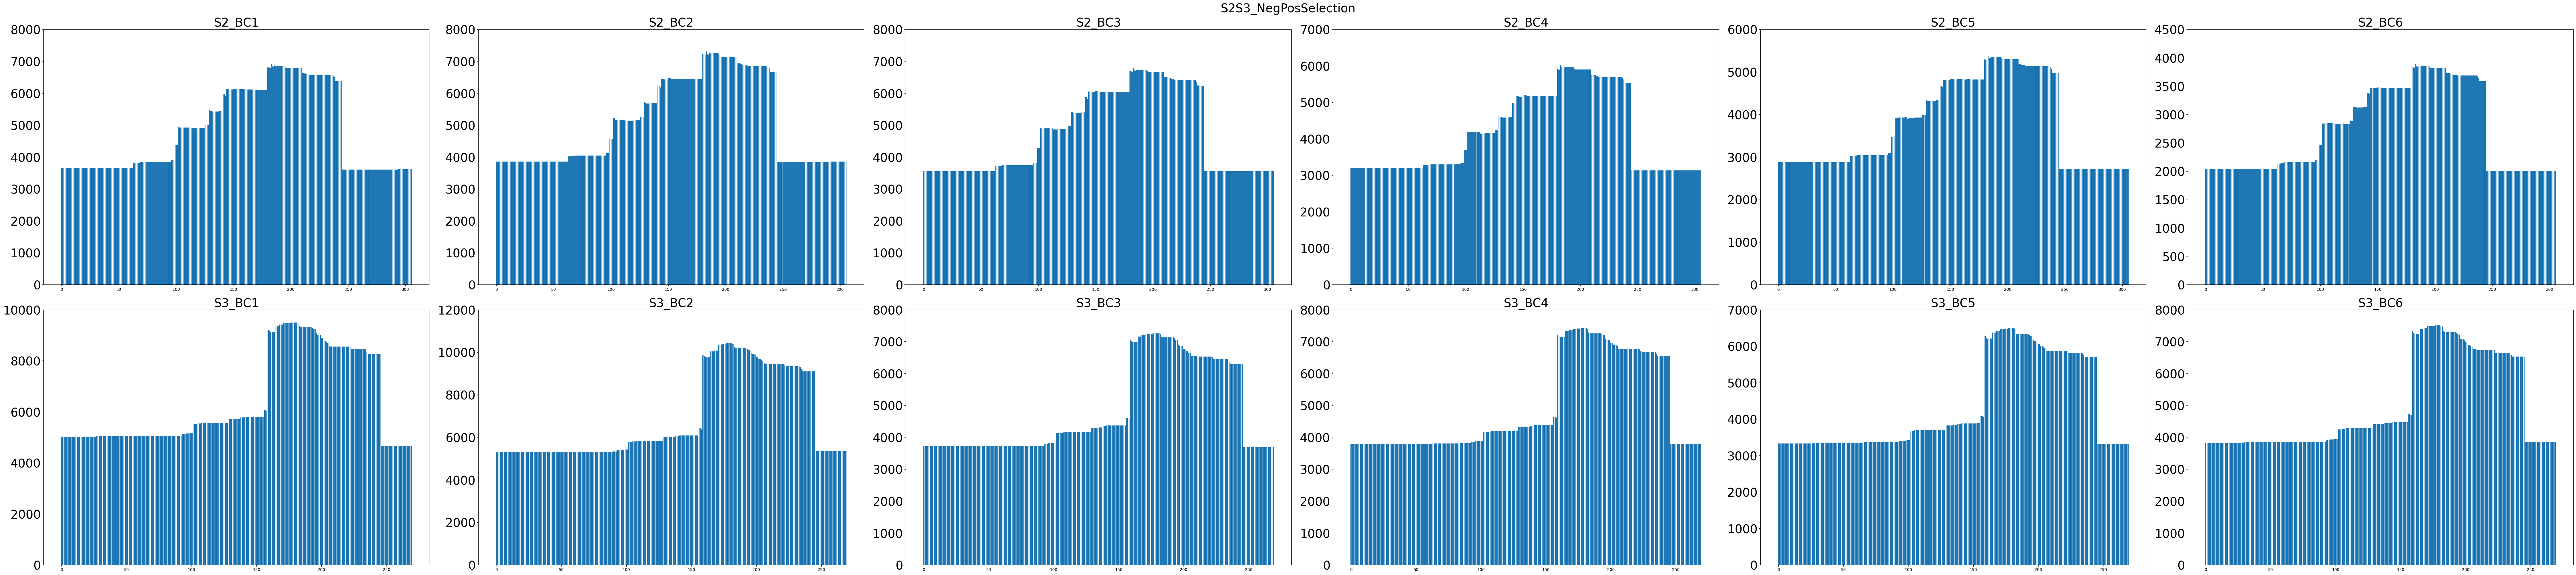

In [104]:
## figure with 4x4 plots of coverages: 
read_dictionary =NegPosSelection_reads
plt_title = "S2S3_NegPosSelection"
used_Barcodes = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]
Sections = ["S2", "S3"]

fig, axs = plt.subplots( len(Sections),len(used_Barcodes), figsize=(15*len(used_Barcodes), 10*len(Sections)), layout='constrained')

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
        tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
        ref_prot_section = translate_dna2aa(ref_seq_Section)

        seq_variants = get_variants(read_dictionary[f"{Bc}_{Section}_R1"], read_dictionary[f"{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_seq_Section, codons = codons)

        seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants["DNA"])
        #seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
        seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants["AA"])
        #seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
        seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants["Codons"])
        #seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants["DNA"].sum().index, seq_variants["DNA"].sum())
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], fontsize = 30)
        ax.set_title(f'{Section}_{Bc}', fontsize = 30)
    
fig.suptitle(plt_title, fontsize = 30)      
#plt.savefig(f'/Users/annavonbachmann/Documents/GitHub/DMS_analysis/output/PACE/Mutagenesis_final_DNA_coverage.pdf')                                                            
plt.show()

In [5]:
#### calculate regions of interest i.e. high mut rate and high coverage
high_mut_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}
low_cov_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}

used_Barcodes_perRun = {"Cycle2Mutagenesis": ["BC1"], 
                        "Cycle2NegPos": ["BC1", "BC2"], 
                        "Mutagenesis": ["BC1", "BC2"], 
                        "NegPosSelection": ["BC1", "BC2", "BC3", "BC4"]}

# used_Barcodes_perRun = {"S2S3alt3cyclesmut": ["BC1", "BC2", "BC3"],
#                         "S2S3alt3cyclesNegPos": ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"],
#                         }
Sections = ["S1", "S2", "S3", "S4"]

cyclenames = ["S2S3alt3cyclesmut", "S2S3alt3cyclesNegPos"]
cyclenames = ["Cycle2Mutagenesis", "Cycle2NegPos", "Mutagenesis", "NegPosSelection"]

for cyclename in cyclenames:
    used_Barcodes = used_Barcodes_perRun[cyclename]
    for section in Sections:
        for Bc in used_Barcodes:
            high_mut_positions,low_cov_pos = find_mutated_pos(read_dict = all_reads, Barcode=Bc, Barcodes=Barcodes, Section=section, ref_gene =ref_gene, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets, codons =codons, data_type = "AA", filter_treshold=0.03,cyclename = cyclename, cov_filter_treshold = 50 ) #####100
            high_mut_pos_dict[section].extend(high_mut_positions)
            low_cov_pos_dict[section].extend(low_cov_pos)

high_mut_pos_dict= {sec: list(set(mut_pos)) for sec, mut_pos in high_mut_pos_dict.items()}


high_mut_pos_dict = {sec:[mut_pos for mut_pos in mut_positions if mut_pos not in low_cov_pos_dict[sec] ] for sec, mut_positions in high_mut_pos_dict.items() }## filter out low coverage positions        

## order dict values
high_mut_pos_dict = {key: [pos for pos in sorted(value)] for key, value in high_mut_pos_dict.items()}

NameError: name 'find_mutated_pos' is not defined

In [10]:
## calculate position-wise chance of mutation from mutagenic spectrum
# mutagenic spectrum
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC1"
cycle = "Mutagenesis"
use_rev_read = False

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)

    #print(pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float"))

    overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    combined_ref_sections.append(ref_seq_Section)

print(overall_mut_spectrum)

overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)

chance_of_no_mut = overall_mut_spectrum_perc.max(axis = 1)

chance_of_mut_pos_dict = {}

for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]

    chance_of_no_mut_pos = [chance_of_no_mut[nt] for nt in ref_seq_Section]
    chance_of_mut_codon_pos = [1-(chance_of_no_mut_pos[pos]*chance_of_no_mut_pos[pos+1]*chance_of_no_mut_pos[pos+2]) for pos in range(0, len(chance_of_no_mut_pos), 3)]
    chance_of_mut_pos_dict[Section] = chance_of_mut_codon_pos


          A         C         G         T
A  801862.0     579.0     277.0     263.0
C     380.0  843420.0      90.0     631.0
G     681.0     176.0  947208.0     926.0
T     150.0     362.0     216.0  778206.0


In [10]:
overall_mut_spectrum_perc

,A,C,G,T
A,0.998606,0.000686,0.000292,0.000338
C,0.000473,0.998696,0.000095,0.000810
G,0.000848,0.000208,0.998121,0.001189
T,0.000187,0.000429,0.000228,0.999065


In [10]:
### plot mutation rates per position (for pos with high mut rates)
FigFolder = None#os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2/repeated_S2S3")
# variants = ["Mutagenesis_BC1", "NegPosSelection_BC1", "NegPosSelection_BC2", "Cycle2Mutagenesis_BC1","Cycle2NegPos_BC1", "Cycle2NegPos_BC2","Mutagenesis_BC2", "NegPosSelection_BC3", "NegPosSelection_BC4"]
# plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]
variants = ['S2S3alt3cyclesmut_BC1',
 'S2S3alt3cyclesmut_BC2',
 'S2S3alt3cyclesmut_BC3',
 'S2S3alt3cyclesNegPos_BC1',
 'S2S3alt3cyclesNegPos_BC2',
 'S2S3alt3cyclesNegPos_BC3',
 'S2S3alt3cyclesNegPos_BC4',
 'S2S3alt3cyclesNegPos_BC5',
 'S2S3alt3cyclesNegPos_BC6'] # use only R1 names 
plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]
Sections = ["S2", "S3"]


# compare_mut_enrichement_for_all(all_reads, ref_gene, Primer_out_of_triplets, Barcodes ,Primer_seq , codons, Sections = Sections, use_rev_read =True, use_forward_read= True, xlim_plot = None,FigFolder = FigFolder, data_type = "AA", combine_mut_rates =False,show_only_pos=high_mut_pos_dict, vmax=0.1, variants = variants, plt_titles = plt_titles, xlabelticks=R5_Pool_AA_annot, fig_size= (35,20)) ### hier fig size in der falschen func geändert-> zurückändern

In [31]:
import plotting
reload(plotting)
from plotting import *

In [32]:

FigFolder = None 
compare_mut_enrichement(all_reads, "S3", ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=False, FigFolder=FigFolder, vmax = 0.05, samples = variants, plt_titles=plt_titles,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq)

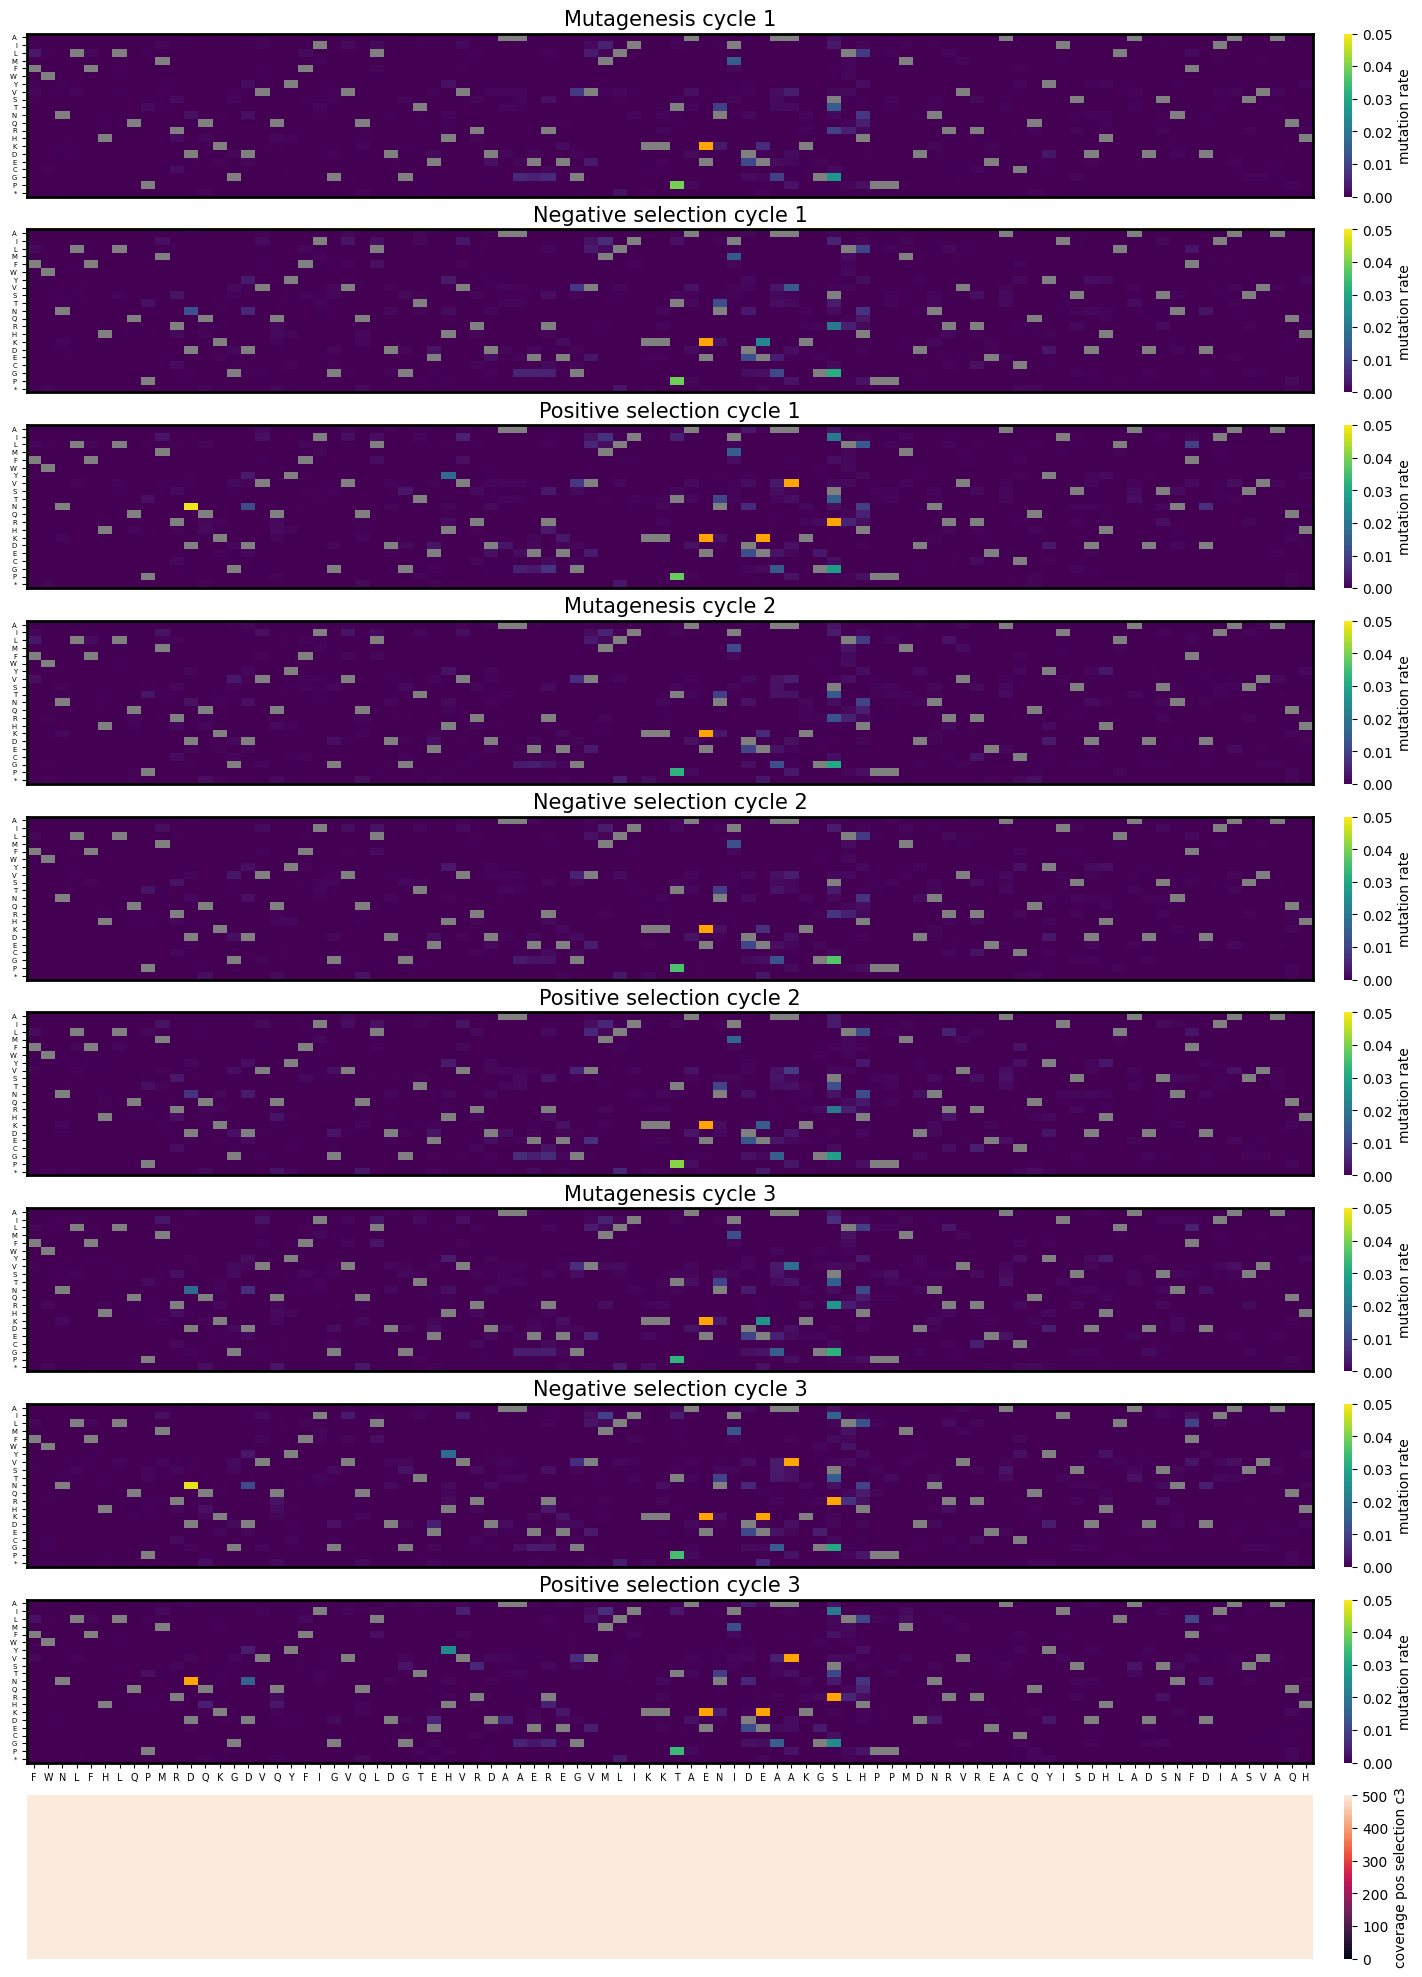

<Figure size 640x480 with 0 Axes>

In [ ]:
FigFolder = None# os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2/repeated_S2S3/AA_muts/")
compare_mut_enrichement(all_reads, "S3", ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=False, FigFolder=FigFolder, vmax = 0.05, variants = variants, plt_titles=plt_titles,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, codons=codons)

In [126]:
## reload the evaluation functions
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import *


In [56]:
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
variant = "NegPosSelection"
mut_rates = []
chance_of_muts = []

for Section in Sections:

    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_gene_section = find_reference_seq(ref_gene=ref_gene,Section = Section, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets)
    ref_prot_section = translate_dna2aa(ref_gene_section)

    a_seq = all_reads[ f"{variant}_{Bc}_{Section}_R1"]
    b_seq = all_reads[ f"{variant}_{Bc}_{Section}_R2"]

    seq_variants = get_variants(a_seq=a_seq, b_seq = b_seq, catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_gene_section, use_forward_read=True, use_rev_read=False, codons = codons)

    seq_variants = pd.DataFrame.from_dict(seq_variants["Codons"])

    coverage_df = pd.DataFrame(seq_variants.sum())
    seq_variants = seq_variants/seq_variants.sum()
    ref =  ref_gene_section 
    ## exclude NAN columns
    seq_variants.dropna(axis = 1, inplace=True)

    plot_df = plot_mutation_enrichment(data = seq_variants, name = variant, ref_seq = ref, data_type = "Codons", return_df=True)
    mut_rates.extend(plot_df.sum(axis = 0))
    chance_of_muts.extend(chance_of_mut_pos_dict[Section][:len(plot_df.sum())])

['GCGAGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGACTTTTTTATTGATCGCCCGCTGGGCATGAAAG', '', 'GCGAGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGC', 'GCGAGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGG', 'GCGAGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCA', '', 'GCGAGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCG

In [60]:
def rank(val_list):
    # Get the sorted list of unique values
    unique_sorted = sorted(set(val_list))

    # Map each value to its rank (index in the sorted list)
    rank_map = {value: rank for rank, value in enumerate(unique_sorted)}

    # Replace each value in 'a' with its rank
    rank_a = [rank_map[value] for value in val_list]
    return rank_a

In [61]:
mut_rates_ranks = rank(mut_rates)
chances_ranks = rank(chance_of_muts)


In [379]:
AAs = list(set(genetic_code.values()))

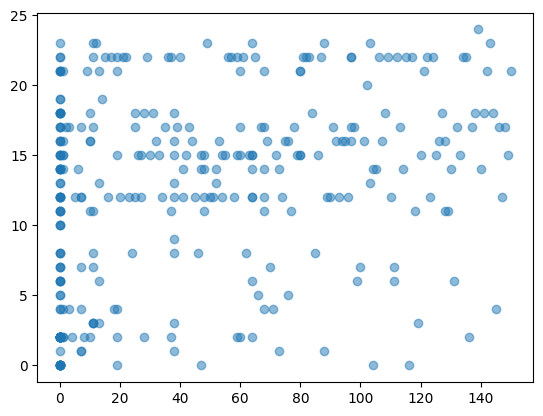

In [62]:
plt.scatter(mut_rates_ranks, chances_ranks, alpha = 0.5)

Text(0, 0.5, 'Chance of codon mutation')

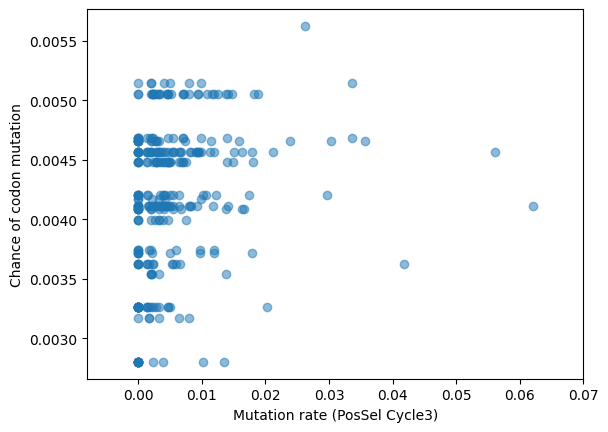

In [64]:
plt.scatter(mut_rates, chance_of_muts, alpha=0.5)
plt.xlim(-0.008, 0.07)
plt.xlabel( "Mutation rate (PosSel Cycle3)" )
plt.ylabel( "Chance of codon mutation")

In [50]:

import scipy.stats
scipy.stats.spearmanr(mut_rates, chance_of_muts)

SignificanceResult(statistic=np.float64(0.3160812986490244), pvalue=np.float64(5.666060607548022e-09))

['', 'AAGGGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGGGAAAGAGGGAAAAATGTCCGGG', 'AAGGGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTG', 'AAGGGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGC', 'AAGGGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAG', 'AAGGGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCC

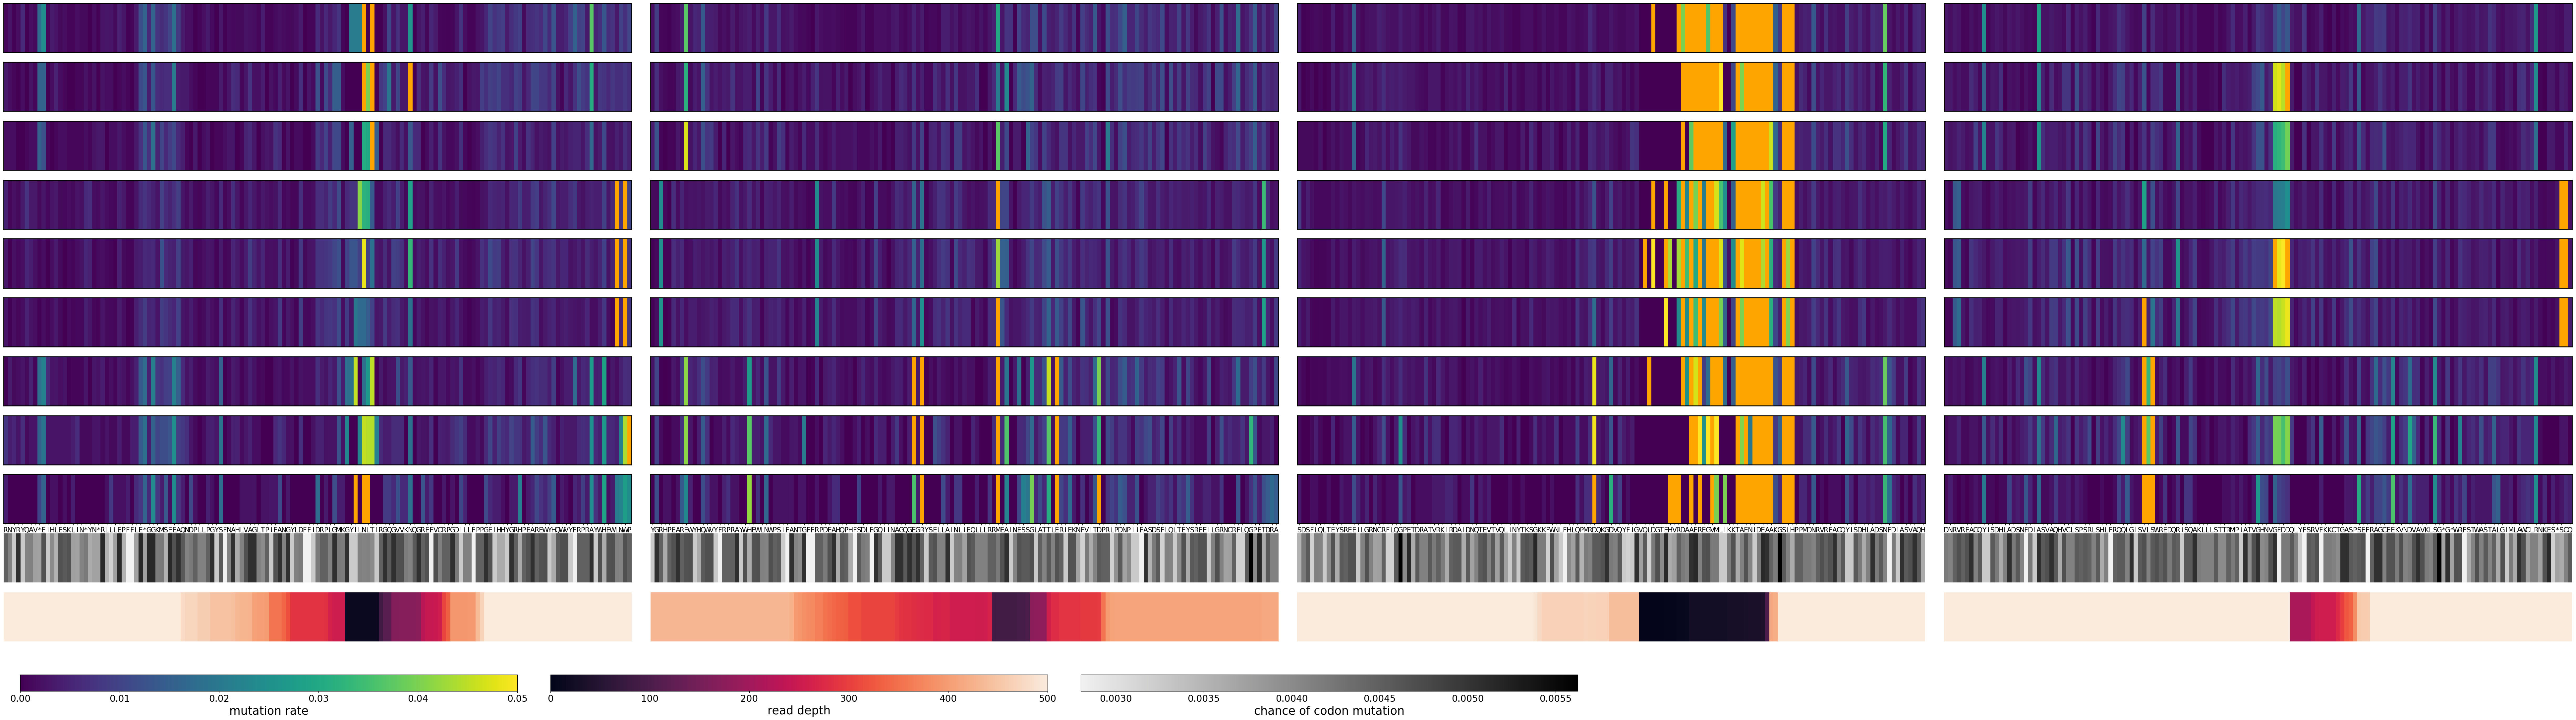

In [69]:
FigFolder = os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
compare_mut_enrichement_for_all(all_reads, ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, variants = ["Mutagenesis_BC1", "NegPosSelection_BC1", "NegPosSelection_BC2", "Cycle2Mutagenesis_BC1", "Cycle2NegPos_BC1", "Cycle2NegPos_BC2" ,"Mutagenesis_BC2", "NegPosSelection_BC3", "NegPosSelection_BC4"], plt_titles =["Mutagenesis 1", "Neg Selection 1", "Pos Selection 1", "Mutagenesis 2", "Neg Selection 2", "Pos Selection 2", "Mutagenesis 3", "Neg Selection  3", "Pos Selection 3"], Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, codons=codons, vmax =0.05, show_cbar_for_each = False, show_plttitles = False,show_only_pos= None, bias_per_pos= chance_of_mut_pos_dict)

In [107]:
## reload the evaluation functions
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import *


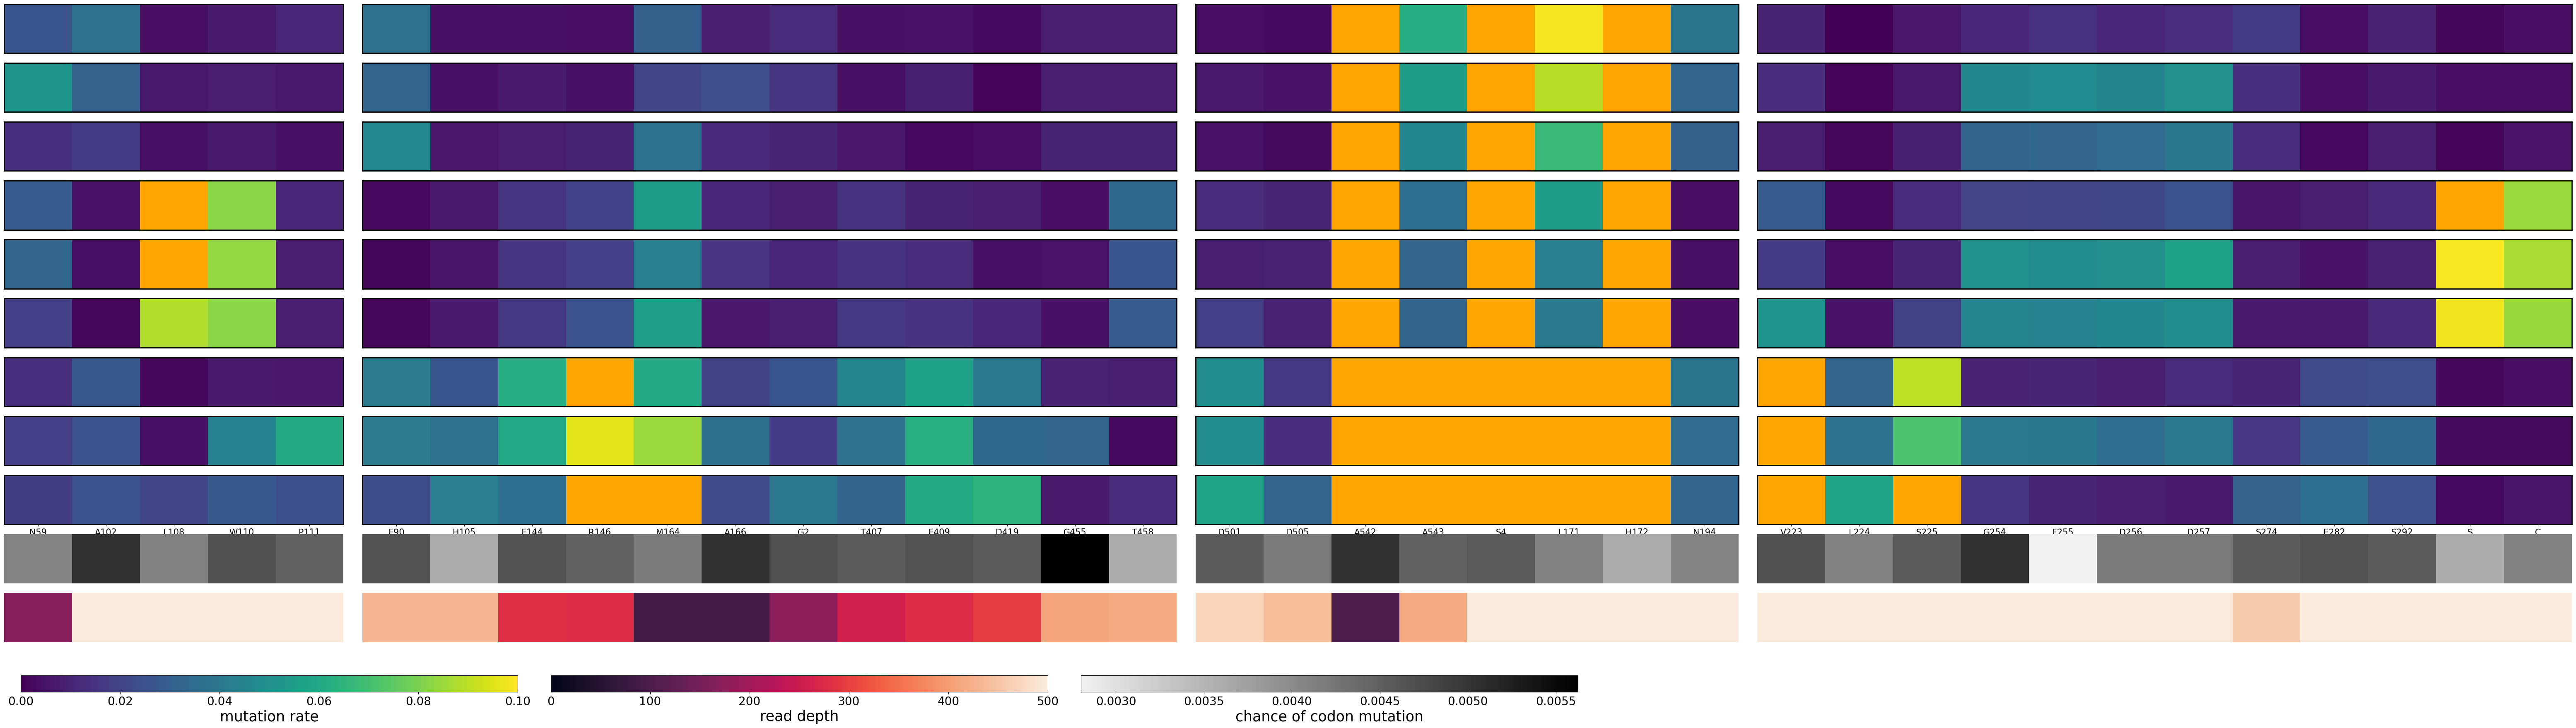

In [209]:
FigFolder =None# os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
most_enriched_regions = compare_mut_enrichement_for_all(all_reads, ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, variants = ["Mutagenesis_BC1", "NegPosSelection_BC1", "NegPosSelection_BC2", "Cycle2Mutagenesis_BC1", "Cycle2NegPos_BC1", "Cycle2NegPos_BC2" ,"Mutagenesis_BC2", "NegPosSelection_BC3", "NegPosSelection_BC4"], plt_titles =["Mutagenesis 1", "Neg Selection 1", "Pos Selection 1", "Mutagenesis 2", "Neg Selection 2", "Pos Selection 2", "Mutagenesis 3", "Neg Selection  3", "Pos Selection 3"], Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, codons=codons, vmax =0.1, show_cbar_for_each = False, show_plttitles = False,show_only_pos= high_mut_pos_dict, bias_per_pos= chance_of_mut_pos_dict, xlabelticks=R5_Pool_AA_annot, return_df = True)

In [210]:
exclude_pos = ["D501",  "D505", "A542",  "A543", "S4", "L171",  "H172", "N194"]
not_exclude = [pos for pos in most_enriched_regions.columns if pos not in exclude_pos]
#most_enriched_regions.loc[:,  not_exclude].max(axis = 1)
show_pos = ["R146", "M164","V223", "S225",  "G254", "F255", "D257"]

In [202]:
#most_enriched_regions = most_enriched_regions.iloc[[0,2,3,5,6,8],:]

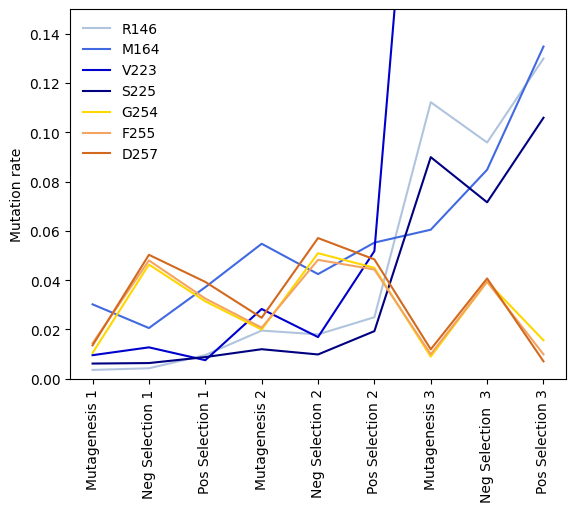

In [211]:
c= ["lightsteelblue","royalblue",  "mediumblue", "navy", "gold", "sandybrown", "chocolate"]
plt.plot(most_enriched_regions.loc[:,  show_pos])
for idx, color in enumerate(c): 
    plt.gca().get_lines()[idx].set_color(color)
plt.xticks( rotation = 90)
plt.ylabel("Mutation rate")
plt.ylim(0,0.15)
plt.legend(labels = show_pos, frameon = False)
plt.savefig(os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2/mut_enrichment_pattern_line_plot.pdf"))
plt.show()

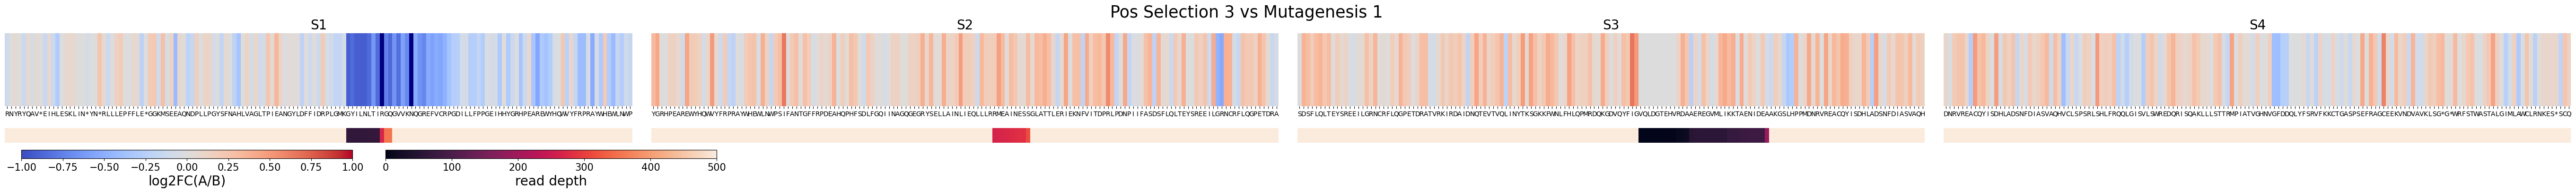

In [60]:
#figfolder = "output/PACE/cycle_mut_enrichment"
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC2"
CylceB = "NegPosSelection" #"Mutagenesis"
BarcodeB = "BC1"
Sections = ["S1", "S2", "S3", "S4"]
name = "Pos Selection 3 vs Mutagenesis 1"
combine_mut_rates=True
vmax = 1
show_cbar_for_each = False
cbar_label = "log2FC(A/B)"

fig = plt.figure(figsize=(70, 3))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.2], width_ratios=[1, 1, 1, 1])

axes = []
for i in range(2):
    row_axes = []
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

fig.suptitle(name, fontsize = 25, y=1.08)

fig.subplots_adjust(wspace=0.03, hspace=0.5)

for idx, Section in enumerate(Sections): 
    stepA = f"{CycleA}_{BarcodeA}_{Section}"
    stepB = f"{CylceB}_{BarcodeB}_{Section}"

    FC_variants, ref, coverage_A, coverage_B = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA", combine_mut_rates=combine_mut_rates)

    my_cmap = plt.get_cmap('coolwarm').copy()
    my_cmap.set_over('saddlebrown')
    my_cmap.set_under('navy')


    #plot_mutation_enrichment(FC_variants,  name = f"{stepA} vs {stepB}", ref_seq=ref, data_type = "AA", fig_folder= None, cmap = "coolwarm", cbar_label=f"log2FC({stepA}/{stepB})", vmax = 0.05)  
    sns.heatmap(pd.DataFrame(FC_variants).T ,cmap = my_cmap, xticklabels=ref, yticklabels=not combine_mut_rates, center = 0, ax = axes[0][idx], cbar = show_cbar_for_each, vmax = vmax, vmin = -vmax if vmax else None ,square = not combine_mut_rates)
    axes[0][idx].set_title(Section, fontsize = 20)
    axes[0][idx].set_xticklabels(axes[0][idx].get_xticklabels(), rotation=1, fontsize=10)
    sns.heatmap(pd.DataFrame(coverage_A).T, linecolor="black", xticklabels=False, yticklabels=False, ax = axes[1][idx], cbar = show_cbar_for_each, vmax = 500, vmin = 0)

if not show_cbar_for_each:
    ## add at the bottom of the figure horizontally a cbar for the relative counts
    cbar_ax = fig.add_axes([0.13, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[0][0].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(axes[0,0].collections[0], cax=cbar_ax)
    # cbar.set_label('relative counts', fontsize = 20)
    # cbar.ax.tick_params(labelsize=15)

    # ## ad cbar also for coverage
    cbar_ax = fig.add_axes([0.24, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[1][3].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label('read depth', fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

#plt.savefig(figfolder + f'/{name.replace(" ", "_")}_log2FC.pdf', bbox_inches="tight")

plt.show()
plt.close()

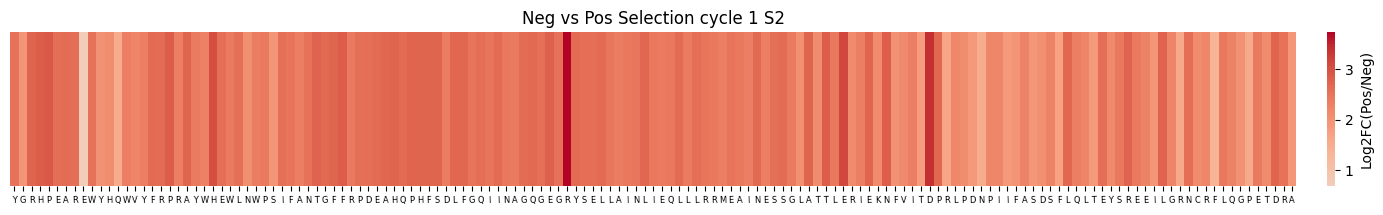

In [53]:
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC4"
CylceB = "Mutagenesis"
BarcodeB = "BC1"
Section = "S2"

stepA = f"{CycleA}_{BarcodeA}_{Section}"
stepB = f"{CylceB}_{BarcodeB}_{Section}"



FC_variants, ref, _,_ = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA",combine_mut_rates=True)

name = "Neg vs Pos Selection cycle 1 "+ Section
plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(FC_variants).T, cmap = "coolwarm", cbar_kws = {"pad": 0.02, "label": "Log2FC(Pos/Neg)" },linecolor="black", xticklabels=ref, yticklabels=False, center = 0)
plt.xticks(rotation = 2,fontsize=6)
plt.title(name)
plt.show()


In [ ]:
# ### set parameters
# variant = "DP6"
# name = "DP6"
# n_mut_treshold = 10
# FigFolder = None #f"{base_dir}/figures/{name}"
# use_rev_read = False
# use_forward_read = True
# arbitrary_cutoff_a = False
# arbitrary_cutoff_b = False


# # if not os.path.exists(FigFolder):
# #     os.makedirs(FigFolder)

# ## read sequences
# seq_variants = process_reads(AA_sequence=amplicon, variants = [variant], use_rev_read=use_rev_read, use_forward_read=use_forward_read, arbitrary_cutoff_a=arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b, n_mut_treshold = n_mut_treshold, filter_for_n_mut=True)

# seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
# seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
# seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
# seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
# seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
# seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

In [713]:
# coverage = seq_variants['DNA'].sum().sum()/(seq_variants['DNA'].max().max()*seq_variants['DNA'].shape[1])*100
# print(f'The illumina paired reads cover on average {coverage.round(1)} % of the ref sequence')

# mut_rate_AA = seq_variants['AA'].max()/seq_variants['AA'].sum()-1
# mut_rate_AA = abs(mut_rate_AA.sum())
# print(f'The mutation rate is estimated to be {mut_rate_AA.round(3)} AA mutations per sequence')
# print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_AA/coverage*100,3)} AA mutations per sequence')

# mut_rate_DNA = seq_variants['DNA'].max()/seq_variants['DNA'].sum()-1
# mut_rate_DNA = abs(mut_rate_DNA.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
# print(f'The mutation rate is estimated to be {mut_rate_DNA.round(3)} DNA mutations per sequence') 
# print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_DNA/coverage*100,3)} DNA mutations per sequence')

# mut_rate_Codons = seq_variants['Codons'].max()/seq_variants['Codons'].sum()-1
# mut_rate_Codons = abs(mut_rate_Codons.sum())
# print(f'The mutation rate is estimated to be {mut_rate_Codons.round(3)} Codon mutations per sequence')
# print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_Codons/coverage*100,3)} Codon mutations per sequence')

# mut_rates_dict = {"variant": name, 
#                   "coverage": coverage,
#                   "AA_mut_per_sequence": mut_rate_AA,
#                   #"AA_mut_per_sequence_coverage_corrected": mut_rate_AA/coverage*100,
#                   "DNA_mut_per_sequence": mut_rate_DNA,
#                   #"DNA_mut_per_sequence_coverage_corrected": mut_rate_DNA/coverage*100, 
#                   "Codon_mut_per_sequence": mut_rate_Codons,
#                   #"Codon_mut_per_sequence_coverage_corrected": mut_rate_Codons/coverage*100
#                   }
# if FigFolder: 
#     with open(f'{FigFolder}/{name}_mutation_rates.json', 'w') as file:
#         file.write(json.dumps(mut_rates_dict, indent=4))

The illumina paired reads cover on average 30.6 % of the ref sequence
The mutation rate is estimated to be 0.396 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.291 AA mutations per sequence
The mutation rate is estimated to be 0.603 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.969 DNA mutations per sequence
The mutation rate is estimated to be 0.516 Codon mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.685 Codon mutations per sequence


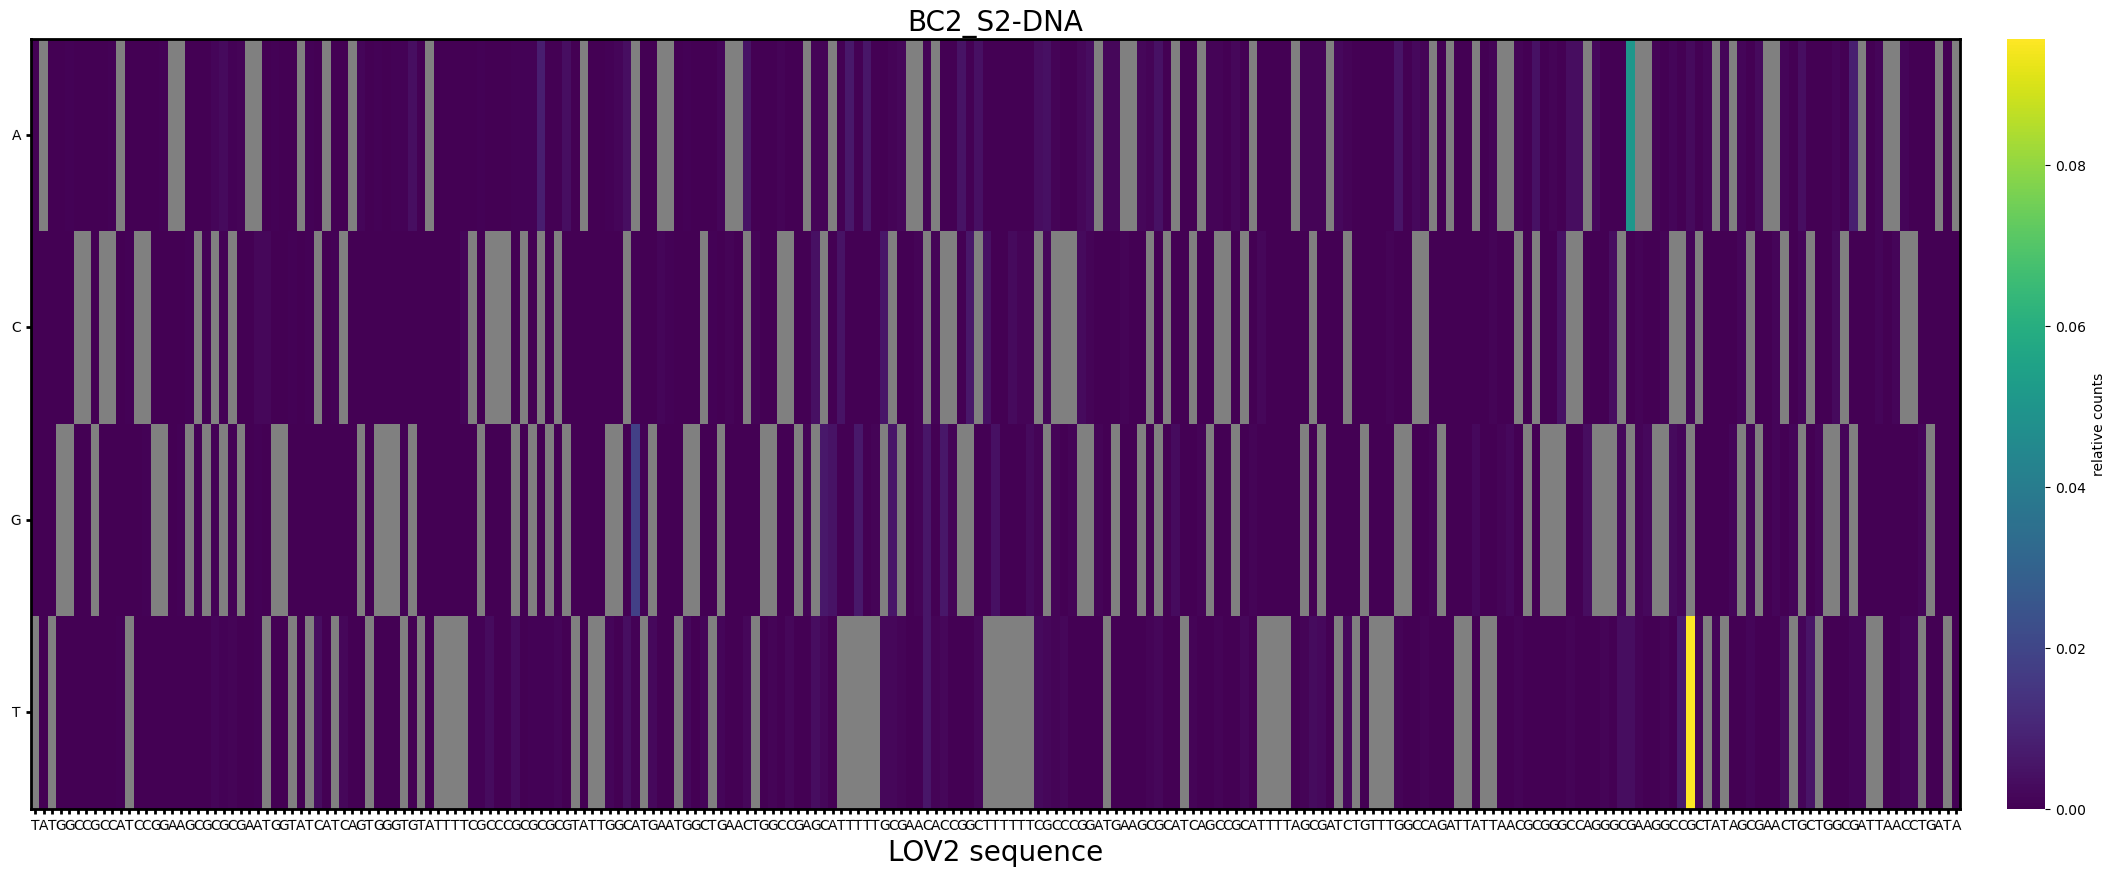

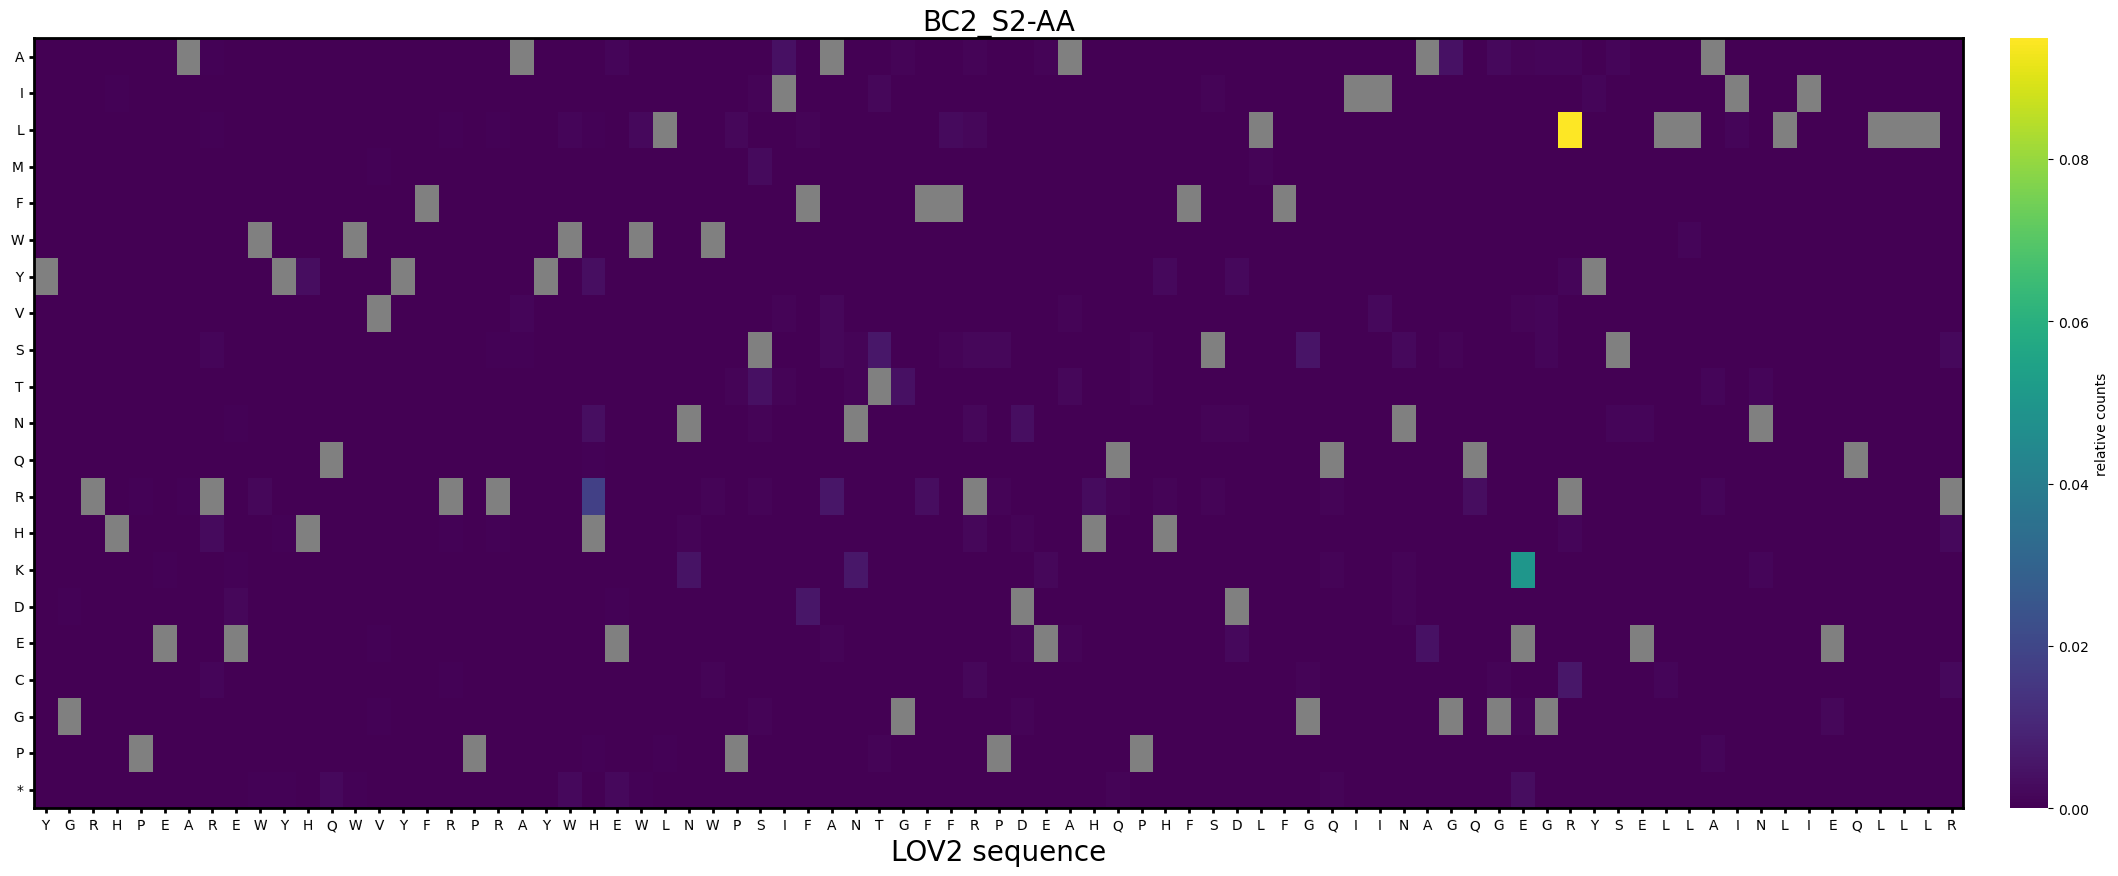

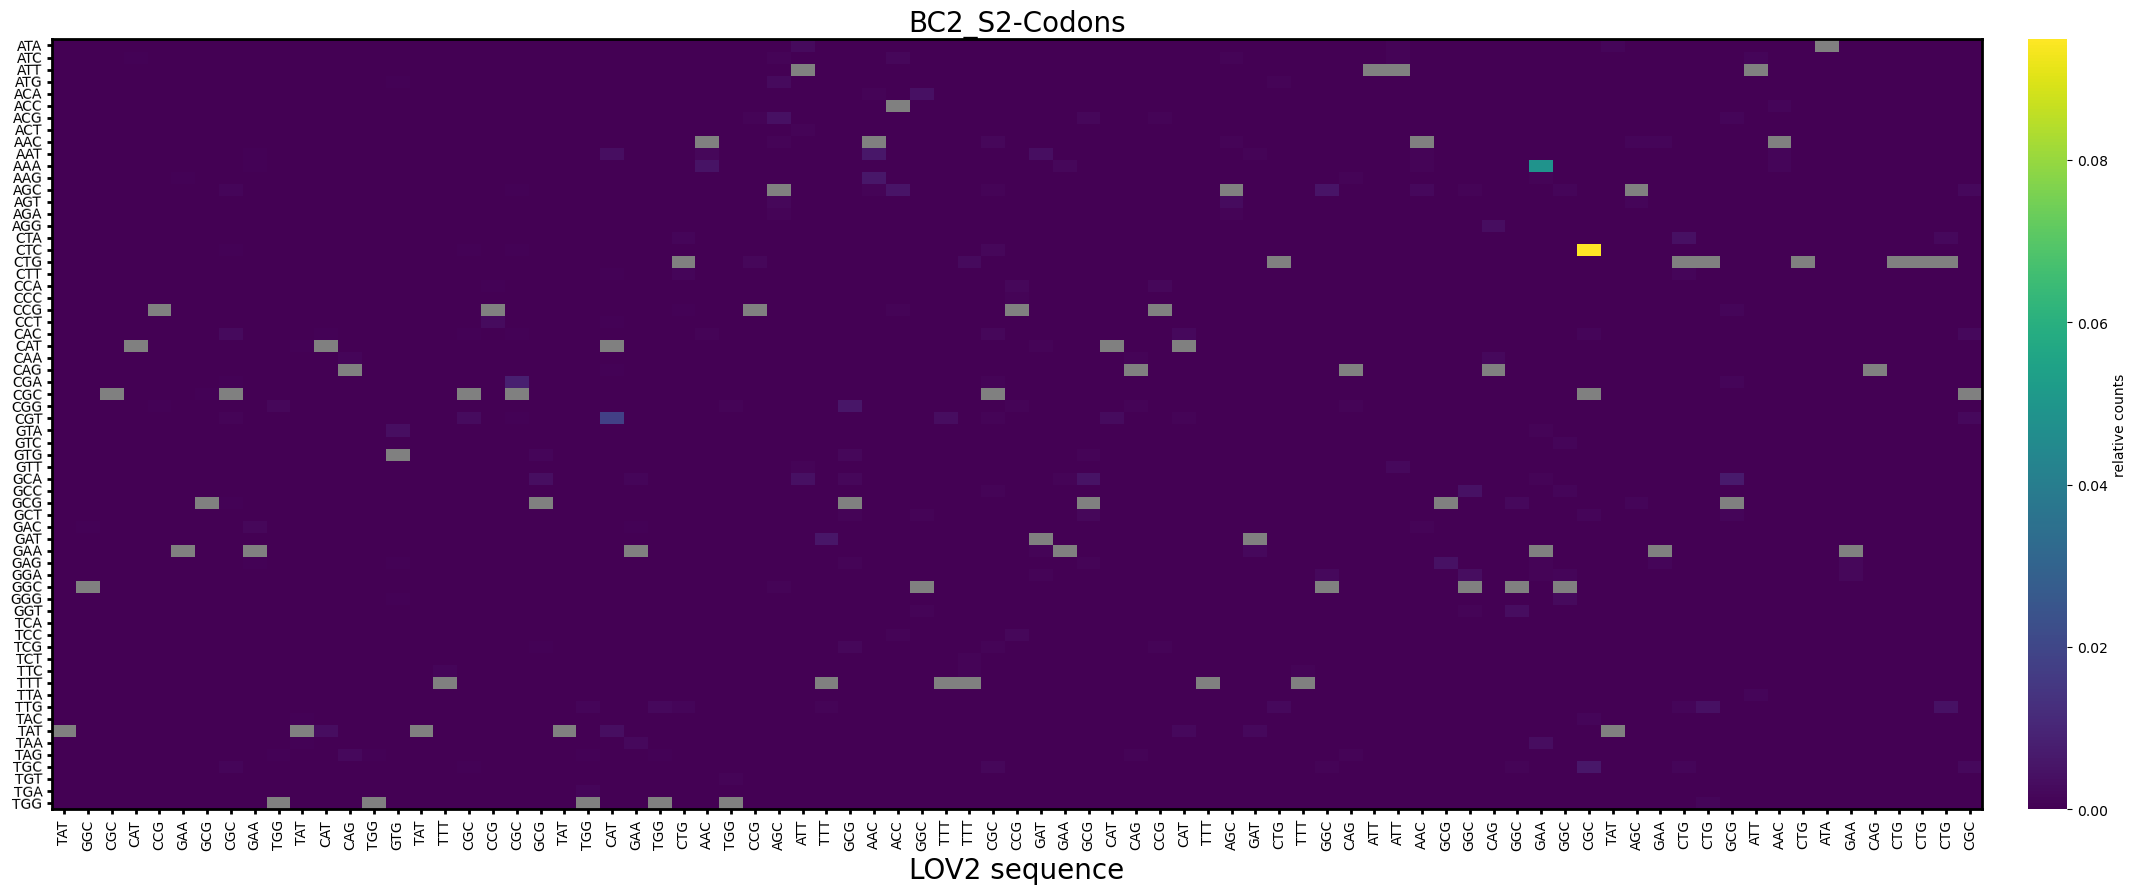

In [714]:
## plot mutation enrichment on DNA, AA and Codon level 

DNA_relative = (seq_variants['DNA']/seq_variants['DNA'].sum()).iloc[:,:225]
DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', reverse= False, data_type = "DNA", ref_seq=ref_seq_Section, fig_folder=FigFolder)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=ref_prot_section,data_type = "AA", reverse =  False, fig_folder=FigFolder)

Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=ref_seq_Section,data_type = "Codons", reverse = False, fig_folder=FigFolder)


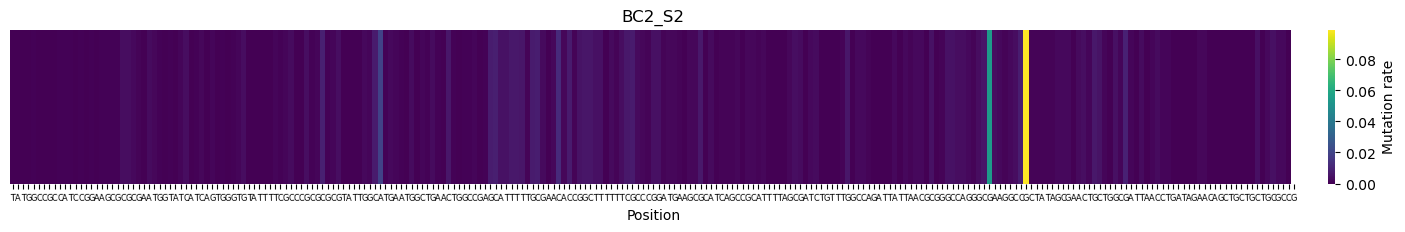

In [715]:
DNA_mut_rate_per_pos = ((seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum())[:245]
plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = name, FigFolder = FigFolder, ref_seq=ref_seq_Section[:245])


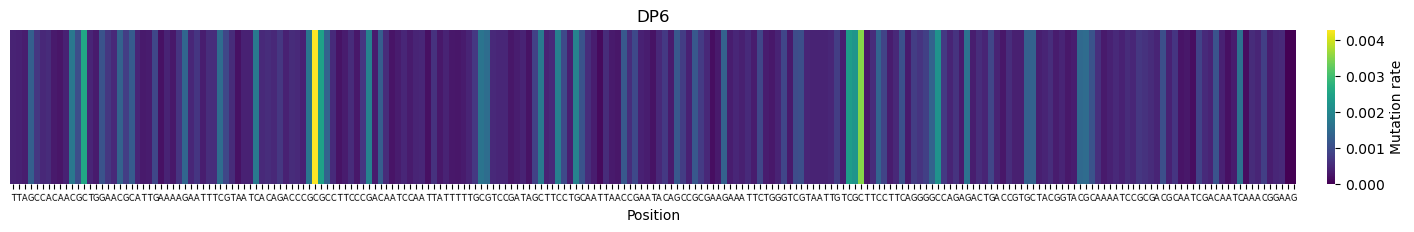

<Figure size 640x480 with 0 Axes>

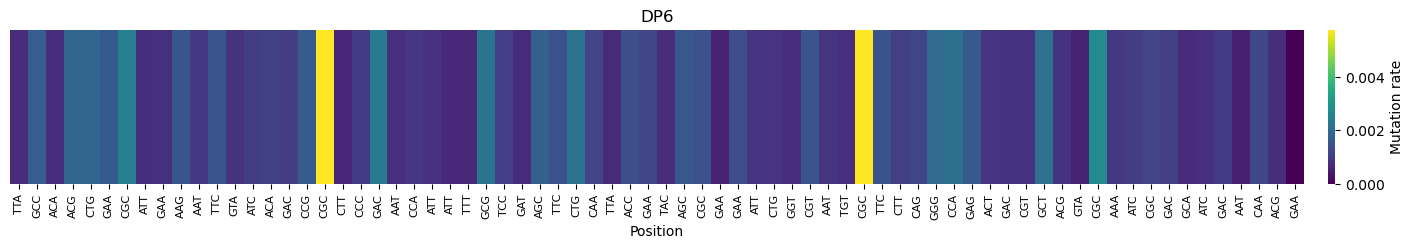

In [44]:
## plot mutation rate per position 
DNA_mut_rate_per_pos = (seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum()

plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = variant, FigFolder = FigFolder)

Codon_mut_rate_per_pos = Codons_relative.sum()-Codons_relative.max()
LOV_codons = [LOV_gene[i:i+3] for i in range(0, len(Codon_mut_rate_per_pos)*3, 3)]

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=LOV_codons, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
#plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Codon_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

In [6]:
Section = "S1"
Bc = "BC1"
tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
ref_prot_section = translate_dna2aa(ref_seq_Section)

seq_variants = get_variants(all_reads[f"Mutagenesis_{Bc}_{Section}_R1"], all_reads[f"Mutagenesis_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),
 ref_prot = ref_prot_section, ref_gene = ref_seq_Section, use_forward_read=True, use_rev_read=False, codons = codons)



In [107]:
all_reads.keys()

dict_keys(['Cycle2Mutagenesis_BC1_S1_R1', 'Cycle2Mutagenesis_BC1_S1_R2', 'Cycle2Mutagenesis_BC1_S2_R1', 'Cycle2Mutagenesis_BC1_S2_R2', 'Cycle2Mutagenesis_BC1_S3_R1', 'Cycle2Mutagenesis_BC1_S3_R2', 'Cycle2Mutagenesis_BC1_S4_R1', 'Cycle2Mutagenesis_BC1_S4_R2', 'Cycle2NegPos_BC1_S1_R1', 'Cycle2NegPos_BC1_S1_R2', 'Cycle2NegPos_BC1_S2_R1', 'Cycle2NegPos_BC1_S2_R2', 'Cycle2NegPos_BC1_S3_R1', 'Cycle2NegPos_BC1_S3_R2', 'Cycle2NegPos_BC1_S4_R1', 'Cycle2NegPos_BC1_S4_R2', 'Cycle2NegPos_BC2_S1_R1', 'Cycle2NegPos_BC2_S1_R2', 'Cycle2NegPos_BC2_S2_R1', 'Cycle2NegPos_BC2_S2_R2', 'Cycle2NegPos_BC2_S3_R1', 'Cycle2NegPos_BC2_S3_R2', 'Cycle2NegPos_BC2_S4_R1', 'Cycle2NegPos_BC2_S4_R2', 'Mutagenesis_BC1_S1_R1', 'Mutagenesis_BC1_S1_R2', 'Mutagenesis_BC1_S2_R1', 'Mutagenesis_BC1_S2_R2', 'Mutagenesis_BC1_S3_R1', 'Mutagenesis_BC1_S3_R2', 'Mutagenesis_BC1_S4_R1', 'Mutagenesis_BC1_S4_R2', 'Mutagenesis_BC2_S1_R1', 'Mutagenesis_BC2_S1_R2', 'Mutagenesis_BC2_S2_R1', 'Mutagenesis_BC2_S2_R2', 'Mutagenesis_BC2_S3_R1', 

In [384]:
# mutagenic spectrum codons
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
cycle = "NegPosSelection"
use_rev_read = False

combined_ref_sections = []


for idx, Section in enumerate(Sections): 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]

    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum_codons(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left="",catch_right="",use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)
    

    if idx == 0:
        overall_mut_spectrum = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    else: 
        overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

    combined_ref_sections.append(ref_seq_Section)

combined_ref_sections = "".join(combined_ref_sections)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100

ref_codons = [combined_ref_sections[i:i+3] for i in range(0, len(combined_ref_sections), 3)]
# np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
# np.fill_diagonal(overall_mut_spectrum.values, np.nan)


36783
28289
44768
56944


In [194]:
overall_mut_spectrum_perc = overall_mut_spectrum_perc.loc[[codon for codon in codons if codon in ref_codons],:]

In [401]:
AAs = list(set(genetic_code.values()))
AA_codons = {Aa: [codon for codon, aa in genetic_code.items() if aa == Aa] for Aa in AAs}

AA_cod_mut_spectrum = pd.DataFrame(index=AAs, columns=codons, data = 0.0)

for aa in AAs:
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_cod_mut_spectrum.loc[aa,:] += overall_mut_spectrum_perc.loc[cod,:]

AA_mut_spectrum = pd.DataFrame(index=AAs, columns=AAs, data = 0.0)
for aa in AAs: 
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_mut_spectrum.loc[:,aa] += AA_cod_mut_spectrum.loc[:,cod]

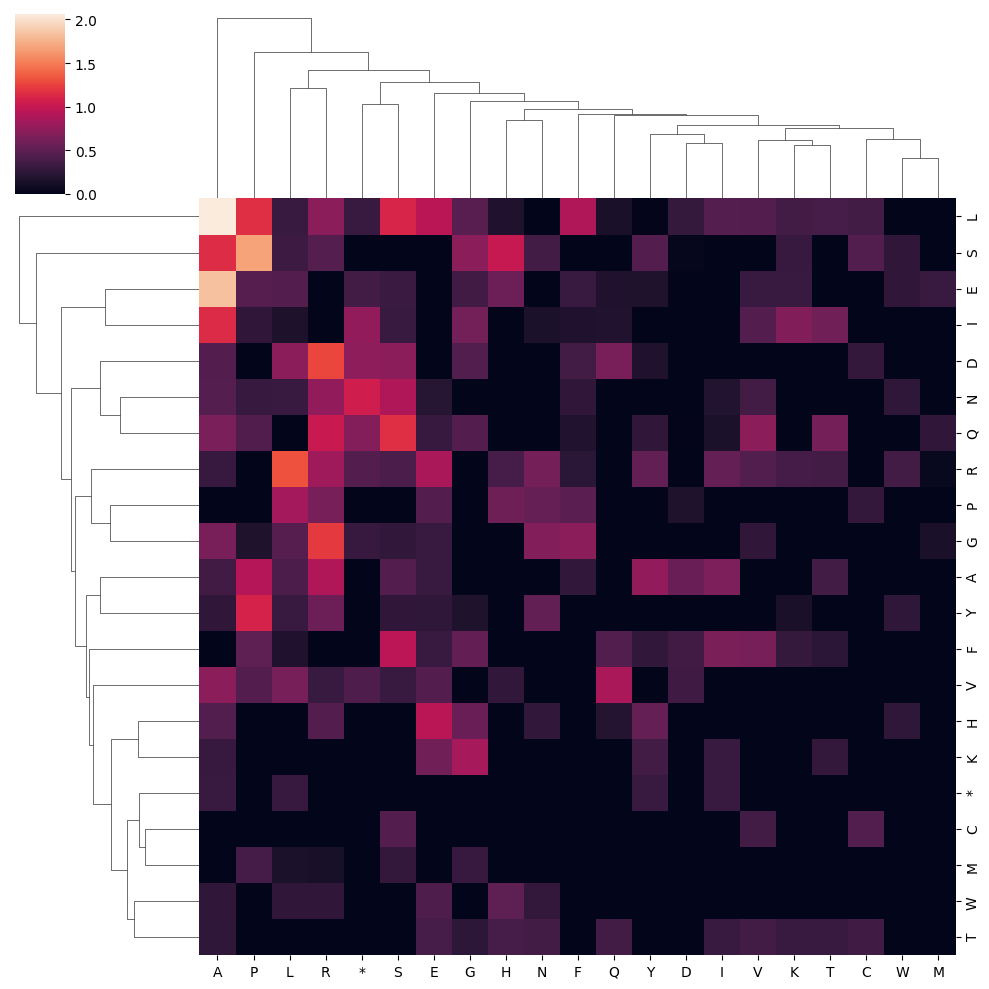

In [402]:
sns.clustermap(AA_mut_spectrum)

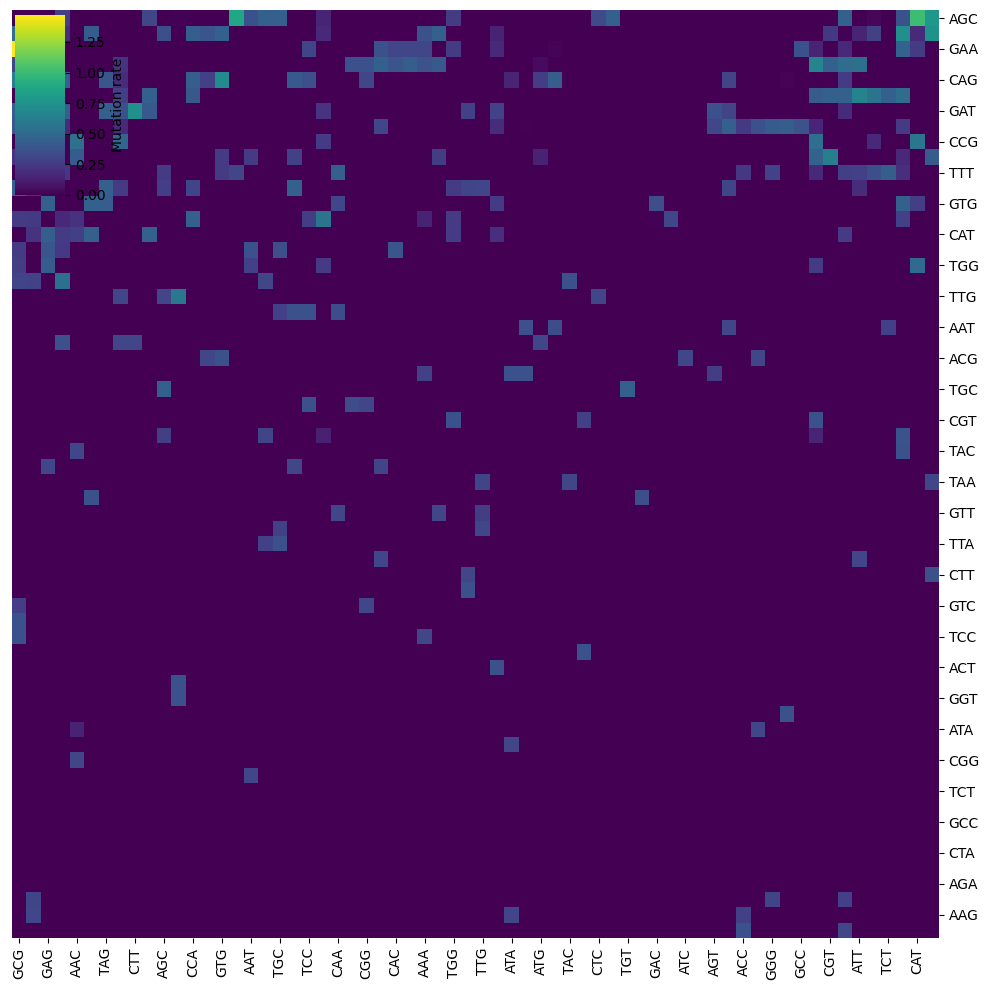

In [195]:
sns.clustermap(overall_mut_spectrum_perc, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", dendrogram_ratio=(.00001, .00001))

In [149]:
overall_mut_spectrum

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATC,0.0,NaN,0.0,0.0,0.0,0.0,591.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATT,0.0,1.0,NaN,1.0,1.0,407.0,2.0,1.0,2.0,4.0,...,1.0,2.0,5.0,1.0,509.0,1.0,0.0,0.0,740.0,1.0
ATG,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ACA,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
TGC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,738.0,0.0,0.0
TGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
TGA,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [181]:
all_reads.keys()

dict_keys(['S2S3alt3cyclesmut_BC1_S2_R1', 'S2S3alt3cyclesmut_BC1_S2_R2', 'S2S3alt3cyclesmut_BC1_S3_R1', 'S2S3alt3cyclesmut_BC1_S3_R2', 'S2S3alt3cyclesmut_BC2_S2_R1', 'S2S3alt3cyclesmut_BC2_S2_R2', 'S2S3alt3cyclesmut_BC2_S3_R1', 'S2S3alt3cyclesmut_BC2_S3_R2', 'S2S3alt3cyclesmut_BC3_S2_R1', 'S2S3alt3cyclesmut_BC3_S2_R2', 'S2S3alt3cyclesmut_BC3_S3_R1', 'S2S3alt3cyclesmut_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC1_S2_R1', 'S2S3alt3cyclesNegPos_BC1_S2_R2', 'S2S3alt3cyclesNegPos_BC1_S3_R1', 'S2S3alt3cyclesNegPos_BC1_S3_R2', 'S2S3alt3cyclesNegPos_BC2_S2_R1', 'S2S3alt3cyclesNegPos_BC2_S2_R2', 'S2S3alt3cyclesNegPos_BC2_S3_R1', 'S2S3alt3cyclesNegPos_BC2_S3_R2', 'S2S3alt3cyclesNegPos_BC3_S2_R1', 'S2S3alt3cyclesNegPos_BC3_S2_R2', 'S2S3alt3cyclesNegPos_BC3_S3_R1', 'S2S3alt3cyclesNegPos_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC4_S2_R1', 'S2S3alt3cyclesNegPos_BC4_S2_R2', 'S2S3alt3cyclesNegPos_BC4_S3_R1', 'S2S3alt3cyclesNegPos_BC4_S3_R2', 'S2S3alt3cyclesNegPos_BC5_S2_R1', 'S2S3alt3cyclesNegPos_BC5_S2_R2', 'S2S3

In [193]:
# mutagenic spectrum
Sections = [ "S2", "S3"]
Bc = "BC1"
cycle = "S2S3alt3cyclesmut"
use_rev_read = True

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)

    print(pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float"))

    overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    combined_ref_sections.append(ref_seq_Section)

chance_of_mutation_df = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)
np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(overall_mut_spectrum.values, np.nan)

print(overall_mut_spectrum)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100



print(overall_mut_spectrum_perc)
print(chance_of_mutation_df)


          A         C         G         T
A  393682.0     224.0     324.0     183.0
C     607.0  413666.0      67.0     641.0
G     673.0      60.0  341847.0     523.0
T     178.0     235.0     331.0  366884.0
          A         C         G         T
A  364917.0    1039.0    2233.0     461.0
C    5712.0  360747.0     507.0    1145.0
G    2151.0     616.0  476528.0     876.0
T     354.0     330.0    1203.0  303707.0
        A       C       G       T
A     NaN  1263.0  2557.0   644.0
C  6319.0     NaN   574.0  1786.0
G  2824.0   676.0     NaN  1399.0
T   532.0   565.0  1534.0     NaN
           A         C          G         T
A        NaN  6.109418  12.368790  3.115174
C  30.566439       NaN   2.776568  8.639288
G  13.660330  3.269966        NaN  6.767281
T   2.573405  2.733033   7.420307       NaN
          A         C         G         T
A  0.994150  0.001613  0.003106  0.000957
C  0.008281  0.988917  0.000697  0.002653
G  0.003701  0.000863  0.994049  0.002078
T  0.000697  0.000721 

In [ ]:
## expected mut spectrum
combined_ref_sections = "".join(combined_ref_sections)
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_nt in combined_ref_sections:
    for mut_nt in ["A", "C", "G", "T"]:
        if ref_nt != mut_nt:
        ## calculate mutagenic spectrum for all expected changes per Nt
            mut_spec_expected[ref_nt][mut_nt] += 1

mut_spec_expected = pd.DataFrame.from_dict(mut_spec_expected, orient='index', dtype = "float")
mut_spec_expected_perc = mut_spec_expected/mut_spec_expected.sum().sum()*100

plot_mutation_spectrum(mut_spec_expected_perc, samplename = "Mutagenesis", fig_folder = None, colormap = "viridis")

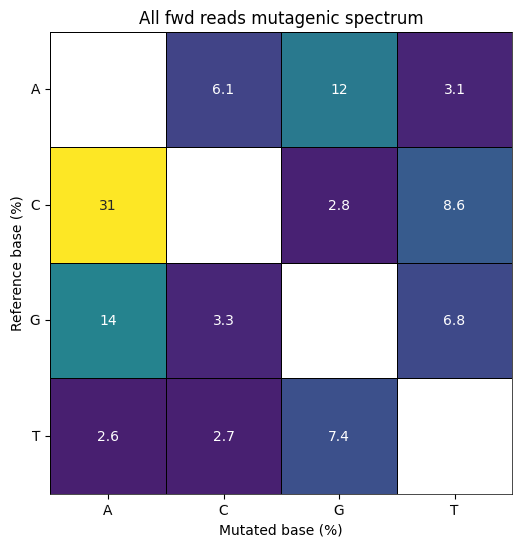

<Figure size 640x480 with 0 Axes>

In [188]:
plot_mutation_spectrum(overall_mut_spectrum_perc,samplename = "All fwd reads",  fig_folder = "output/PACE/repS2S3/")

In [86]:
all_reads.keys()

dict_keys(['S2S3alt3cyclesmut_BC1_S2_R1', 'S2S3alt3cyclesmut_BC1_S2_R2', 'S2S3alt3cyclesmut_BC1_S3_R1', 'S2S3alt3cyclesmut_BC1_S3_R2', 'S2S3alt3cyclesmut_BC2_S2_R1', 'S2S3alt3cyclesmut_BC2_S2_R2', 'S2S3alt3cyclesmut_BC2_S3_R1', 'S2S3alt3cyclesmut_BC2_S3_R2', 'S2S3alt3cyclesmut_BC3_S2_R1', 'S2S3alt3cyclesmut_BC3_S2_R2', 'S2S3alt3cyclesmut_BC3_S3_R1', 'S2S3alt3cyclesmut_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC1_S2_R1', 'S2S3alt3cyclesNegPos_BC1_S2_R2', 'S2S3alt3cyclesNegPos_BC1_S3_R1', 'S2S3alt3cyclesNegPos_BC1_S3_R2', 'S2S3alt3cyclesNegPos_BC2_S2_R1', 'S2S3alt3cyclesNegPos_BC2_S2_R2', 'S2S3alt3cyclesNegPos_BC2_S3_R1', 'S2S3alt3cyclesNegPos_BC2_S3_R2', 'S2S3alt3cyclesNegPos_BC3_S2_R1', 'S2S3alt3cyclesNegPos_BC3_S2_R2', 'S2S3alt3cyclesNegPos_BC3_S3_R1', 'S2S3alt3cyclesNegPos_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC4_S2_R1', 'S2S3alt3cyclesNegPos_BC4_S2_R2', 'S2S3alt3cyclesNegPos_BC4_S3_R1', 'S2S3alt3cyclesNegPos_BC4_S3_R2', 'S2S3alt3cyclesNegPos_BC5_S2_R1', 'S2S3alt3cyclesNegPos_BC5_S2_R2', 'S2S3

In [100]:
## Look for coocurrence of mutations in the same read (choose positive selection cylce 3)
## specifically E144K and R146L mutations
## is in Section 2
Section = "S2" 
Bc = "BC5"
read_of_interest = all_reads[f"S2S3alt3cyclesNegPos_{Bc}_{Section}_R1"]#[f"NegPosSelection_{Bc}_{Section}_R1"] ## fwd read section 2 pos selection cycle 3
region = "ISVLS" 
region = "QGEGR"

## find the positions of the mutations

tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
ref_gene_section = find_reference_seq(ref_gene = R5_Pool_seq, Primer_seq = Primer_seq, Section = Section, Primer_out_of_triplets = Primer_out_of_triplets)
ref_protein_section = translate_dna2aa(ref_gene_section)

catch_left = Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st]
AA_seqs = [translate_dna2aa(dna[dna.index(catch_left)+len(catch_left):]) for dna in read_of_interest if catch_left in dna]

index_of_interest = ref_protein_section.index(region)
sections_of_interest = [AA_seq[index_of_interest:index_of_interest+len(region)] for AA_seq in AA_seqs] 
sections_of_interest = [sec for sec in sections_of_interest if len(sec)==len(region)]## keep only those that have the region of interest

## find occurences of mutations
coocurrence = {}
for sec in sections_of_interest:
    if sec[2:] not in coocurrence:
        coocurrence[sec[2:]] = 1
    else: 
        coocurrence[sec[2:]] += 1

## order coocurrence after value size
coocurrence = dict(sorted(coocurrence.items(), key=lambda item: item[1], reverse=True))
## filter for coocurrence > 1 (exclude seq errors)
coocurrence = {key: value for key, value in coocurrence.items() if value > 5}

In [101]:
coocurrence

{'EGR': 2451, 'EGL': 241, 'KGR': 137, 'KGL': 19, 'VGR': 6, 'AGR': 6}

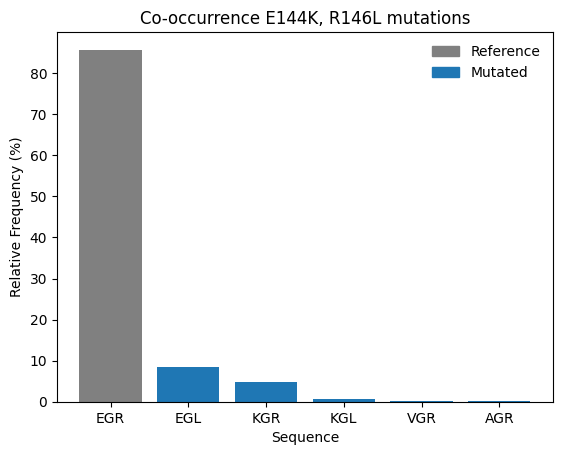

In [103]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey
plt.title("Co-occurrence E144K, R146L mutations")#V223M, L224M, S225R mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooccurence_E144K_R146L_repSeqS2.pdf")

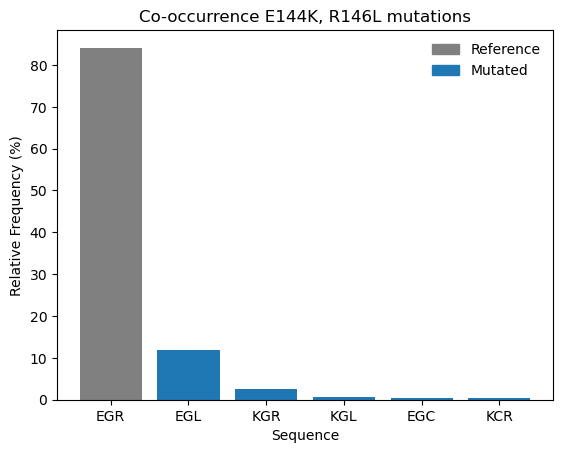

In [36]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey

plt.title("Co-occurrence E144K, R146L mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooocurrence_E144K_R146L.pdf")